<a href="https://colab.research.google.com/github/jmestanza/Echo_cancellation/blob/master/Pruebas_con_Adasip_Autovalores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports de paquetes utilizados en el proyecto

In [0]:
%cd /content/


#!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_lento.wav"
#wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_lento.wav"

!wget "https://raw.githubusercontent.com/jmestanza/Echo_cancellation/master/test_audios/speech.wav/subjectm1/left-headed/m1lcapum.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Echo_cancellation/master/test_audios/speech.wav/subjectm1/left-headed/m1lmacum.wav"

!pip install https://github.com/DavidDiazGuerra/gpuRIR/zipball/master
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import numpy.matlib
from math import ceil

import matplotlib.pyplot as plt
import wave, struct, math, random

from scipy.io.wavfile import read
from scipy import *

from IPython.display import clear_output
import IPython.display as ipd
from IPython.display import Audio
clear_output()

import gpuRIR

##Obtención de datos de prueba para los algoritmos

In [0]:
def sync_signals(u,d,init_delay,evLen,fs):
    u = u[int(0):int((evLen)*fs)]
    d = d[int((init_delay)*fs):int((init_delay+evLen)*fs)]
    return u, d

def adjustSignals(fs,u,d):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))

    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ

def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos


def read_wavs(audio_file,grab_file):
    file_name = grab_file
    fs, grab_audio = get_mono_array(file_name)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio = grab_audio - np.mean(grab_audio)
    print("fs de la grabacion ",fs, "nombre", file_name)

    file_name = audio_file
    fs, audio = get_mono_array(file_name)

    audio /= np.max(np.abs(audio),axis=0)
    audio = audio-np.mean(audio)
    print("fs del audio ",fs, "nombre", file_name)
    return audio,grab_audio,fs

"""signals = {'log':['/content/sweep_lento.wav','/content/grab_sweep_lento.wav',0.648,10.936]}

sound="log"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)"""


file="m1lmacum.wav"
fs, audio = get_mono_array(file)
audio /= np.max(np.abs(audio),axis=0)
audio /= np.max(np.abs(audio),axis=0)
audio = audio - np.mean(audio)

gpuRIR.activateMixedPrecision(False)

## Simulación de la respuesta al impulso de la habitación

In [0]:
gpuRIR.activateMixedPrecision(False)

def GetRoomWithMov(audio,audio_len,room_x=3,room_y=3.5,room_z=2.5,phone_len=0.2,traj_pts=20):

  room_sz = [room_x,room_y,room_z]  # Size of the room [m]
  print("La habitación es de",room_x," ", room_y," ",room_z," m")
  y_coord=np.random.rand()*room_y
  x_start=np.random.rand()*room_x/2
  x_end=x_start+0.1*audio_len
  pos_traj = np.tile(np.array([x_start,y_coord,1.75]), (traj_pts,1))
  pos_traj[:,0] = np.linspace(x_start, x_end, traj_pts) # Positions of the trajectory points [m]
  nb_rcv = 1 # Number of receivers
  pos_rcv = np.tile(np.array([x_start+phone_len,y_coord,1.75]), (traj_pts,1))
  pos_rcv[:,0] = np.linspace(x_start+phone_len, x_end+phone_len, traj_pts) # Positions of the trajectory points [m]
  print("Se arrancó en",[x_start,y_coord,1.75])
  print("Se terminó en",[x_end,y_coord,1.75])
  orV_rcv = np.array([[-1,0,0],[1,0,0]])
  mic_pattern = "card" # Receiver polar pattern
  T60 = 0.8 # Time for the RIR to reach 60dB of attenuation [s]
  att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
  att_max = 70.0 # Attenuation at the end of the simulation [dB]

  beta = gpuRIR.beta_SabineEstimation(room_sz, T60,abs_weights = [0.8]*5+[0.5]) # Reflection coefficients
  Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
  Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
  nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
  fs=16000
  numeros=np.random.randint(traj_pts, size=5)
  t = np.arange(int(ceil(Tmax * fs))) / fs

  plt.figure(figsize=(7,7))
  for i in range(0,10): 
    imp=gpuRIR.simulateRIR(room_sz, beta, pos_traj[i,:], pos_rcv[i,:], nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)
    #temp_plot=10*np.log10(np.absolute(imp[0,0,:]))
    temp_plot=imp[0,0,:]
    plt.plot(t, temp_plot)
    array = np.asarray(temp_plot)
    #idxs = np.array(np.where(np.absolute(temp_plot-(-60)) < 0.2))
    #print(idxs[0,len(idxs[0,:])-1]/fs)
  #plt.ylim((-180,-25))
  plt.ylabel('Room Impulse Response')
  plt.xlabel('Time [s]')
  plt.grid(True)
  plt.show()

  RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_traj, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

  filtered_signal = gpuRIR.simulateTrajectory(audio, RIRs)
  plt.plot(audio,label="Original")
  plt.plot(filtered_signal[:,0],label="Filtrada")
  plt.legend(loc='upper right')
  plt.xlabel('Muestras')
  plt.ylabel('Amplitud')
  plt.title('Señal de entrada y señal deseada')
  plt.grid(True, which="both")
  plt.show()
  return filtered_signal[:,0]

##Algoritmo NLMS

In [4]:
#NLMS Algorithm
import numpy as np
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos

def NLMS(M, mu, delta, u, d):
    w = np.zeros((M,len(u)))
    e = np.zeros(len(u))
    u_star = np.zeros(M-1)
    uaux = np.concatenate((u_star, u), axis=None)
    y = np.zeros(len(u))
    energias_u = []
    
    for i in range(0,len(u)):
        if i == 0:
            e[0] = d[0] 
            y[0] = 0
            w[:,i]=np.zeros(M)
        else:
            y[i] = np.dot(w[:,i-1].conj().transpose(),uaux[i:i+M])
            e[i] = d[i]-y[i]
            energias_u.append(np.dot(uaux[i:i+M],uaux[i:i+M]))
            nu = mu/(np.dot(uaux[i:i+M],uaux[i:i+M]) + delta)
            w[:,i] = w[:,i-1] + nu *  uaux[i:i+M] * (e[i].conj())
    return w, np.power(e,2)/len(e), y, np.array(energias_u)

"""auxuz = uZ[len(uZ)//2:len(uZ)//2+1000]
auxdz = dZ[len(dZ)//2:len(dZ)//2+1000]

mu = 1
delta = 1
its = 10
M = 10

w, J, y, energias_u= NLMS(M, mu, delta, np.flip(auxuz), np.flip(auxdz))

plt.plot(y)
plt.plot(np.flip(auxdz))
plt.show()"""

'auxuz = uZ[len(uZ)//2:len(uZ)//2+1000]\nauxdz = dZ[len(dZ)//2:len(dZ)//2+1000]\n\nmu = 1\ndelta = 1\nits = 10\nM = 10\n\nw, J, y, energias_u= NLMS(M, mu, delta, np.flip(auxuz), np.flip(auxdz))\n\nplt.plot(y)\nplt.plot(np.flip(auxdz))\nplt.show()'

In [5]:
"""#ploteo de las energías de u en histograma para NLMS
n, bins, patches = plt.hist(x=energias_u, bins=43, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de las energías de u')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)"""

"#ploteo de las energías de u en histograma para NLMS\nn, bins, patches = plt.hist(x=energias_u, bins=43, color='#0504aa',\n                            alpha=0.7, rwidth=0.85)\nplt.grid(axis='y', alpha=0.75)\nplt.xlabel('Value')\nplt.ylabel('Frequency')\nplt.title('Histograma de las energías de u')\nmaxfreq = n.max()\n# Set a clean upper y-axis limit.\nplt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)"

##Algoritmo Fast Block LMS

In [43]:
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos


def getBlock(M,subArray,k):
    block = np.zeros((M,M))
    for i in range(M):
        block[:,i] = np.flip(subArray[(k*M +i): (k*M +i+M)])
    return block
def getBlocks(M,number_of_blocks,new_u,new_d):
    blocks_u = []
    blocks_d = []
    for i in range(number_of_blocks):
        blocks_u.append(getBlock(M,new_u,i)) 
        blocks_d.append(getBlock(M,new_d,i))

    blocks_u = np.array(blocks_u)
    blocks_d = np.array(blocks_d)
    return blocks_u, blocks_d

def FastBlockNLMS(M, u, d, delta, gamma, mode):
    N = 2*M
    d_list = np.zeros(0)
    y_list = np.zeros(0)
    W = np.zeros(N)
    W = W.astype(complex)
    original_len = len(u)
    P = np.zeros((N,N))
    P[:,-1] = np.ones(N)*delta # init de P
     
    new_u = np.concatenate((np.zeros(M-1),u), axis= None)
    new_d = np.concatenate((np.zeros(M-1),d), axis= None)

    number_of_blocks = original_len//M

    blocks_u, blocks_d = getBlocks(M, number_of_blocks, new_u,new_d)

    # el algoritmo empieza aca    
    for k in range(number_of_blocks - 1):    
        u_concat = np.concatenate((blocks_u[k],blocks_u[k+1]),axis=1) # concateno dos bloques
        u_concat = np.concatenate((u_concat,np.zeros((M,N))), axis = 0) # overlap and save
        u_concat = u_concat.astype(complex)
        for i in range(N):
            u_concat[i,:] = np.fft.fft(u_concat[i,:]) # esto hace la fft en filas
        U = u_concat.diagonal() # esta U es de longitud 2N  
        for l in range(N):
            P[:,l] = gamma* P[:,l-1] + (1-gamma)* np.power(np.abs(U),2)

        D = np.power(P.diagonal(),-1)
        y = np.fft.ifft(U*W).real
        y = y[len(y)-M:] 
        y_list = np.concatenate((y_list,y), axis=None)
        d = blocks_d[k][0,:]
        d_list = np.concatenate((d_list,d), axis=None)
        e = d-y
        E = np.fft.fft(np.concatenate((np.zeros(M),e),axis = None))
        if mode == "pot":
            #pot = np.sum(np.power(np.abs(U),2))
            pot = np.dot(blocks_u[k][0,:],blocks_u[k][0,:])
            phi = np.fft.ifft(U.conj()*E).real[:M] 
            W += (gamma/pot)*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))
        elif mode == "mejorconv":
            phi = np.fft.ifft(np.matmul(D,U.conj().T)*E).real[:M] 
            W += gamma*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))

    return y_list, d_list

"""auxu = uZ[len(uZ)//2:len(uZ)//2+1000]
auxd = dZ[len(dZ)//2:len(dZ)//2+1000]

y_list, d_list =FastBlockNLMS(50,auxu,auxd, delta=1, gamma = 0.1, mode = "pot")

plt.plot(normalize(y_list))
plt.plot(normalize(d_list))"""

'auxu = uZ[len(uZ)//2:len(uZ)//2+1000]\nauxd = dZ[len(dZ)//2:len(dZ)//2+1000]\n\ny_list, d_list =FastBlockNLMS(50,auxu,auxd, delta=1, gamma = 0.1, mode = "pot")\n\nplt.plot(normalize(y_list))\nplt.plot(normalize(d_list))'

In [7]:
"""plt.plot(normalize(auxu))
plt.plot(normalize(auxd))"""

'plt.plot(normalize(auxu))\nplt.plot(normalize(auxd))'

##Ejemplo de Fast Block LMS con Adafilt

In [8]:
#remuevo adafilt si es que existe
%cd /content
!rm -rf adafilt

/content


In [0]:
# clono adafilt e instalo
%cd /content
!git clone https://github.com/fhchl/adafilt
%cd /content/adafilt 
!python setup.py install

clear_output()

Iteración Nº 0
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.7196679121344504, 4.3405826036488735, 1.75]
Se terminó en [1.9696679121344505, 4.3405826036488735, 1.75]


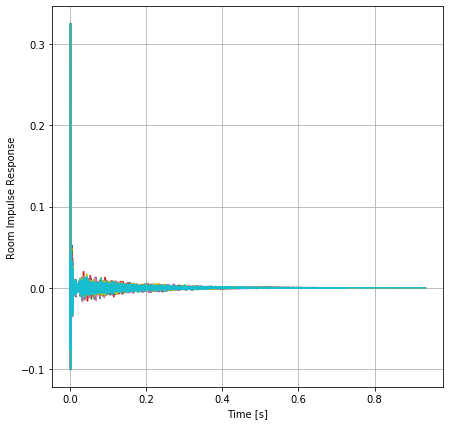

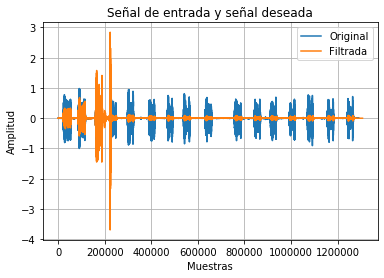

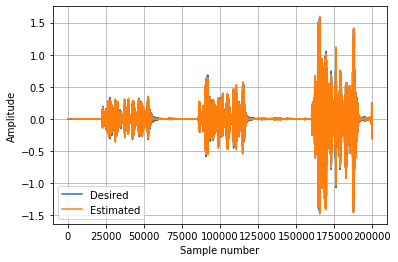

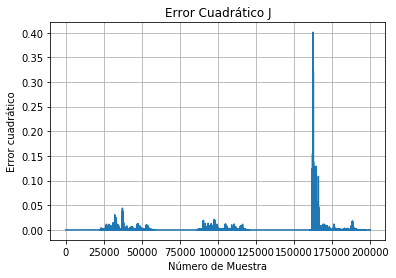

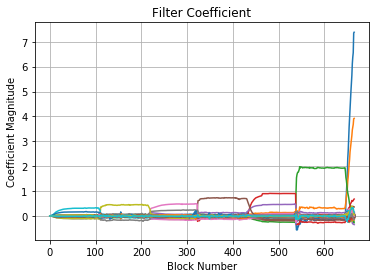

El valor máximo de error cuadrático es 0.40090275978873474
Tardó  6.1712822914123535  segundos
Iteración Nº 1
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.19606228338125353, 1.7570126089056983, 1.75]
Se terminó en [1.4460622833812535, 1.7570126089056983, 1.75]


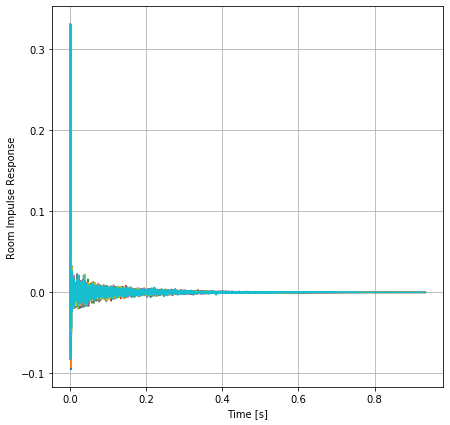

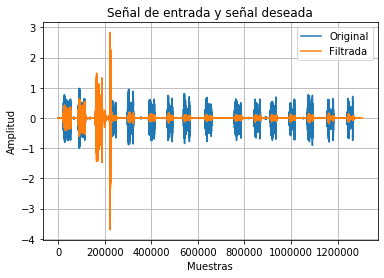

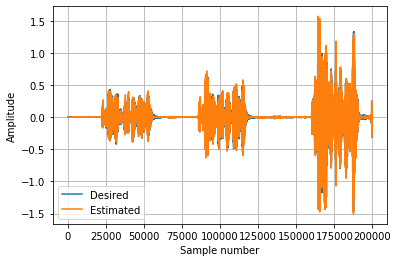

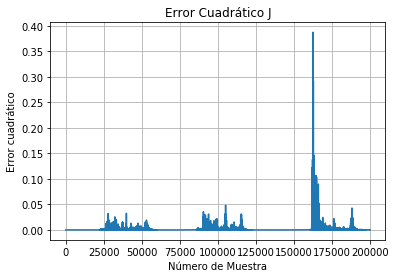

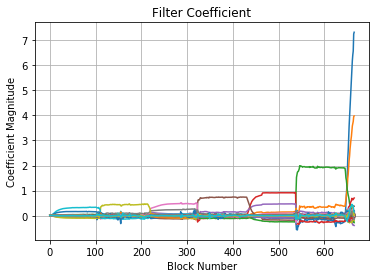

El valor máximo de error cuadrático es 0.3872866307572456
Tardó  5.9549901485443115  segundos
Iteración Nº 2
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.2520352445135587, 4.113907710246616, 1.75]
Se terminó en [1.5020352445135587, 4.113907710246616, 1.75]


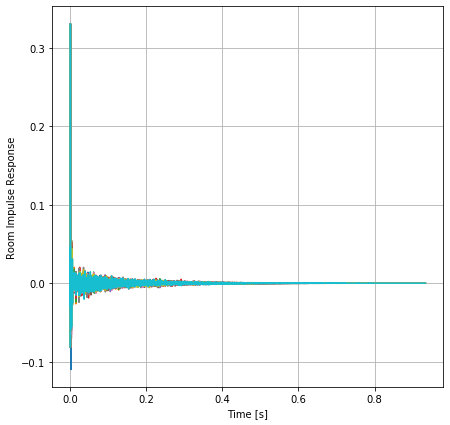

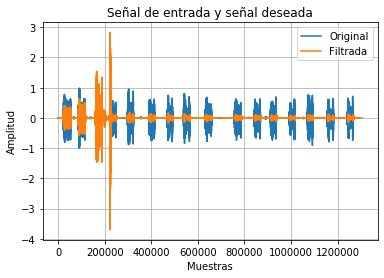

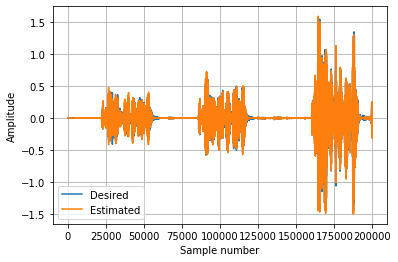

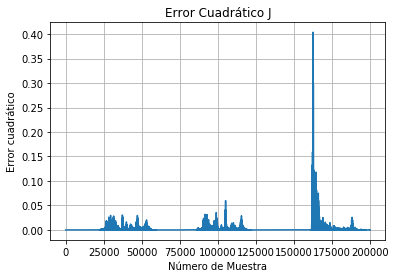

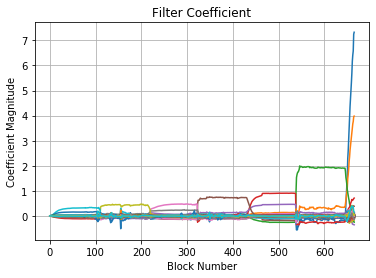

El valor máximo de error cuadrático es 0.4038361996084952
Tardó  6.167218208312988  segundos
Iteración Nº 3
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.8487005094085582, 1.0247698873089388, 1.75]
Se terminó en [2.098700509408558, 1.0247698873089388, 1.75]


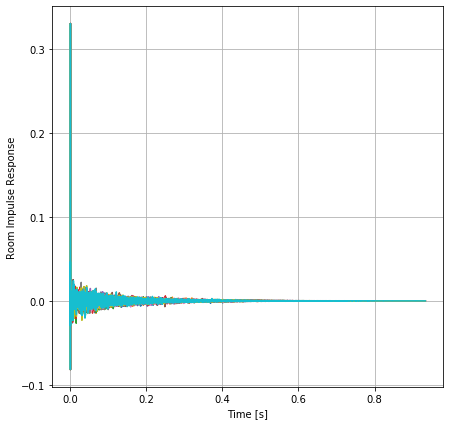

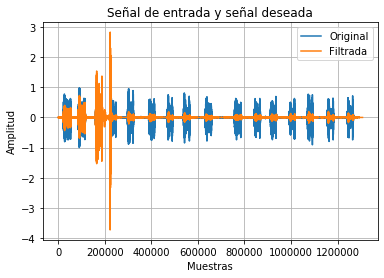

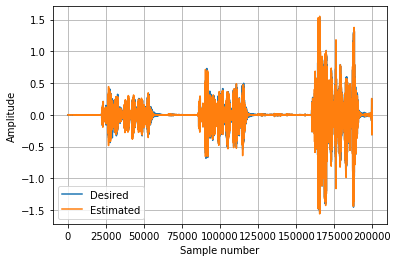

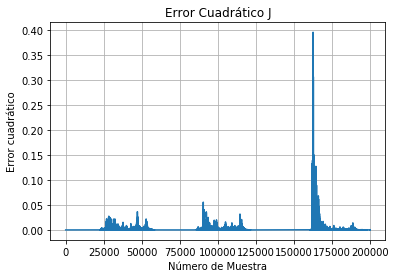

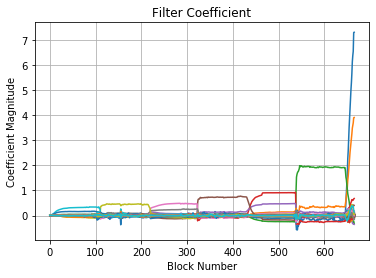

El valor máximo de error cuadrático es 0.3952672097989766
Tardó  5.982368230819702  segundos
Iteración Nº 4
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.5626785016667164, 0.35076037236304464, 1.75]
Se terminó en [1.8126785016667164, 0.35076037236304464, 1.75]


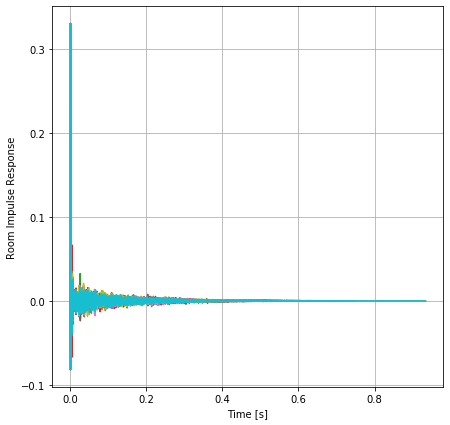

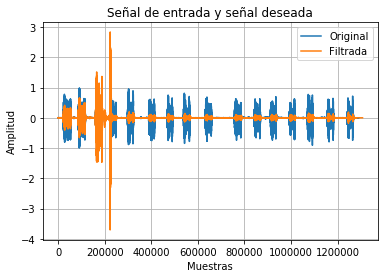

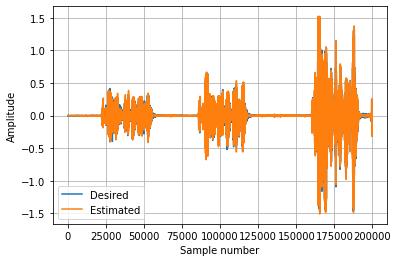

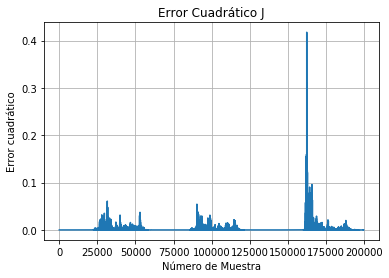

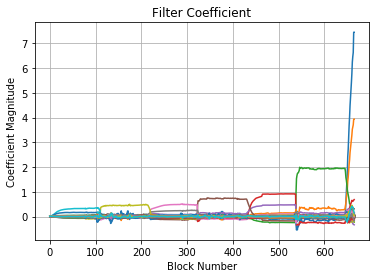

El valor máximo de error cuadrático es 0.41769301712059753
Tardó  6.129844427108765  segundos
Iteración Nº 5
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.2253755910407171, 0.2187343786907176, 1.75]
Se terminó en [2.4753755910407174, 0.2187343786907176, 1.75]


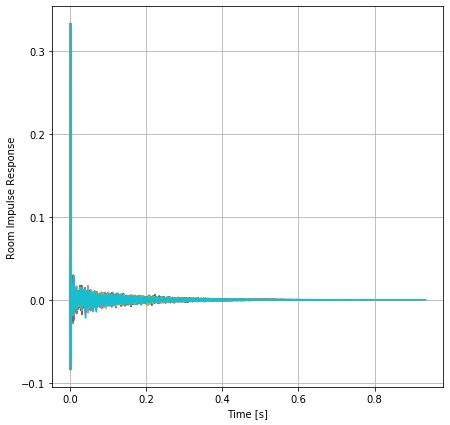

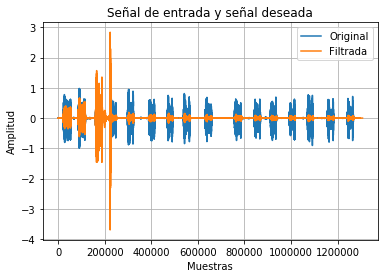

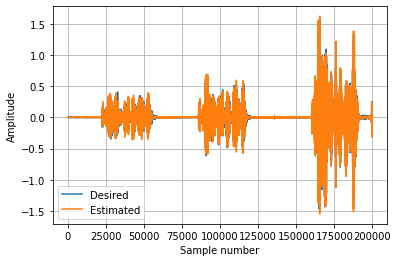

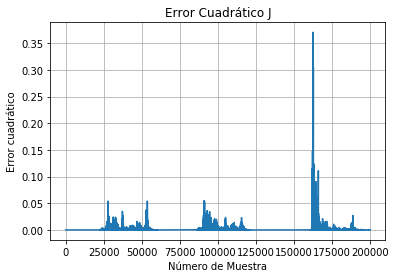

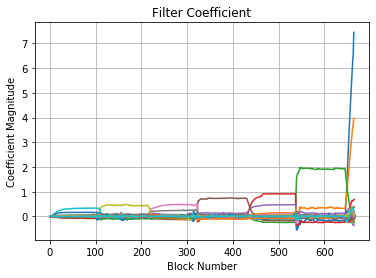

El valor máximo de error cuadrático es 0.37069440433922723
Tardó  5.973384380340576  segundos
Iteración Nº 6
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.3518622185468043, 1.2597500210484445, 1.75]
Se terminó en [2.6018622185468043, 1.2597500210484445, 1.75]


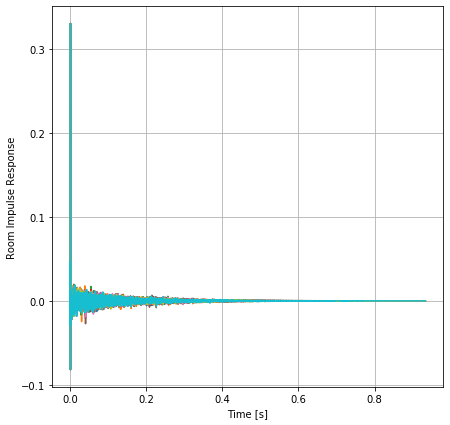

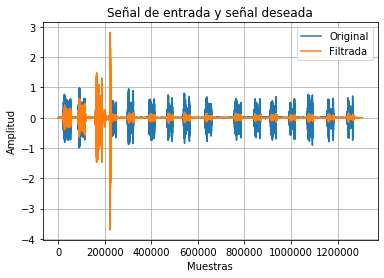

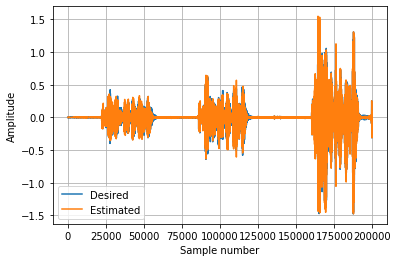

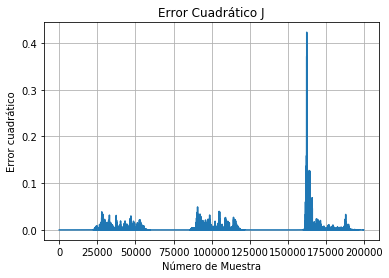

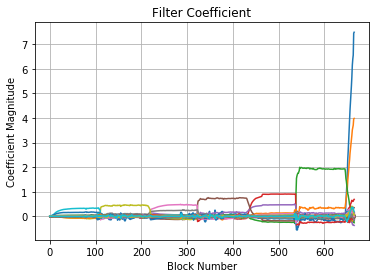

El valor máximo de error cuadrático es 0.4231504652557805
Tardó  6.212686538696289  segundos
Iteración Nº 7
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.7694304127422649, 2.5149604055551826, 1.75]
Se terminó en [2.019430412742265, 2.5149604055551826, 1.75]


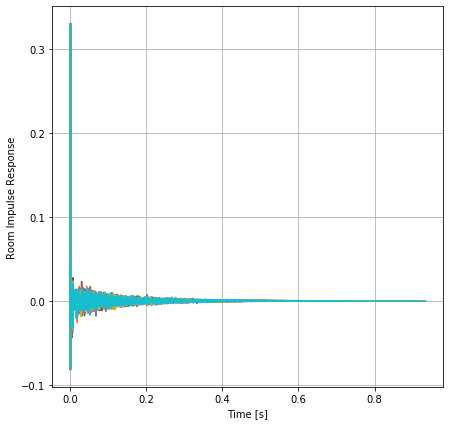

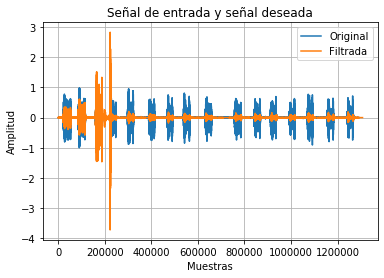

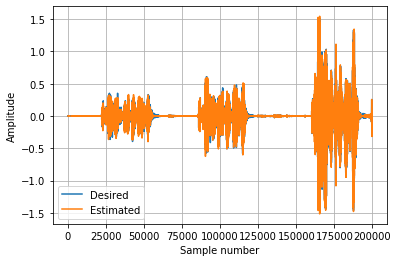

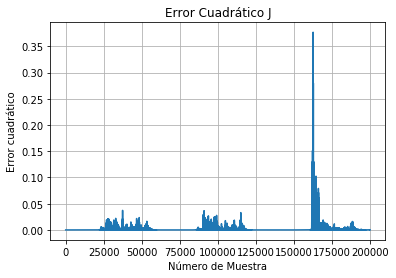

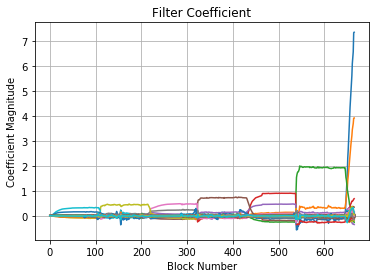

El valor máximo de error cuadrático es 0.3768517634247879
Tardó  5.938695430755615  segundos
Iteración Nº 8
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.340641955174996, 3.394505865064071, 1.75]
Se terminó en [2.5906419551749957, 3.394505865064071, 1.75]


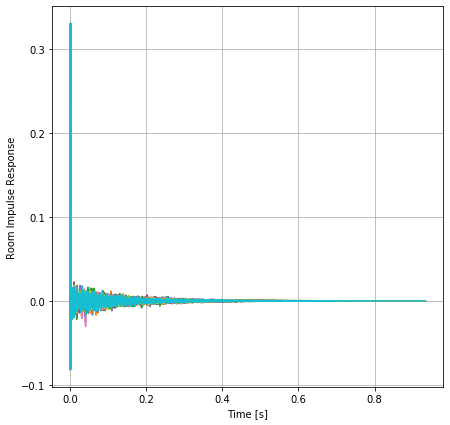

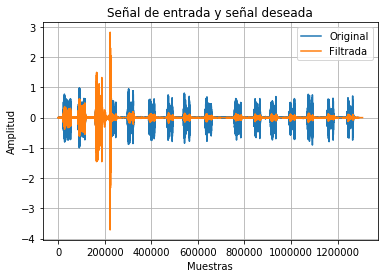

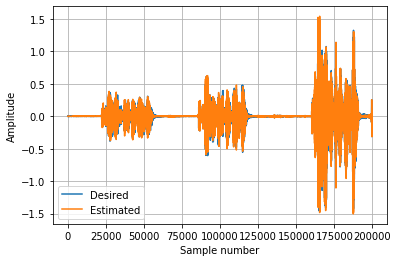

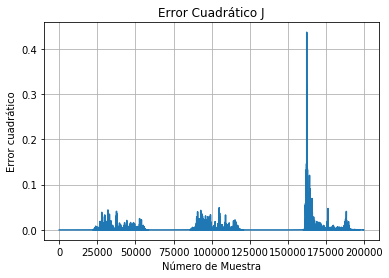

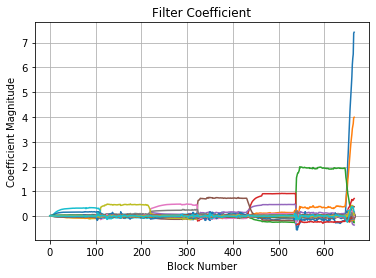

El valor máximo de error cuadrático es 0.436397098260142
Tardó  6.1990721225738525  segundos
Iteración Nº 9
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.338252087077042, 3.906997979387552, 1.75]
Se terminó en [2.5882520870770422, 3.906997979387552, 1.75]


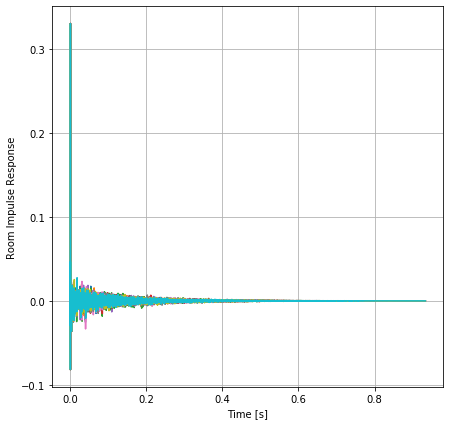

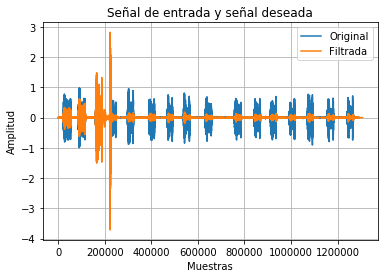

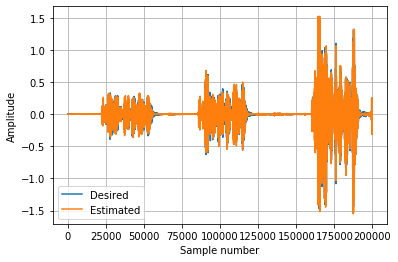

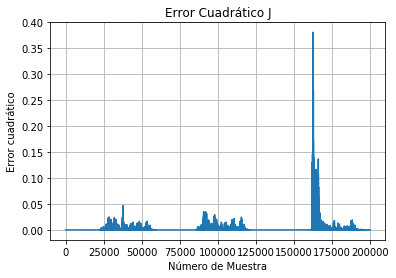

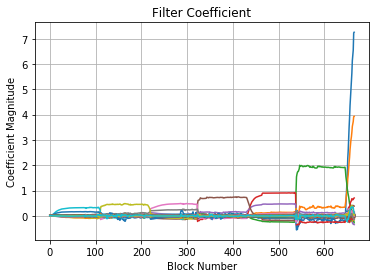

El valor máximo de error cuadrático es 0.3810487667793275
Tardó  5.977368354797363  segundos
Iteración Nº 10
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.8696813065670316, 1.546121964699031, 1.75]
Se terminó en [2.1196813065670317, 1.546121964699031, 1.75]


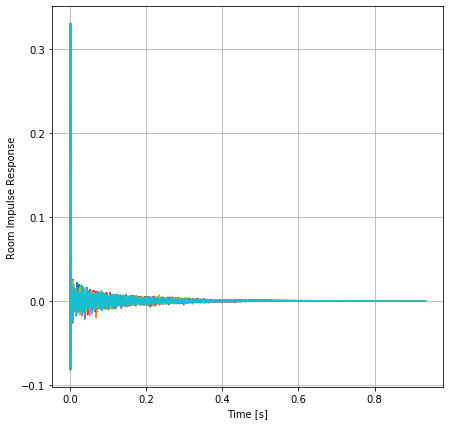

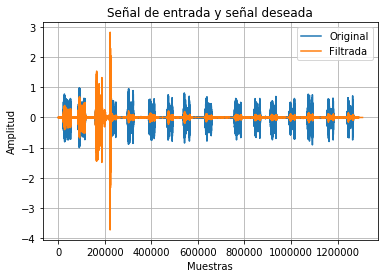

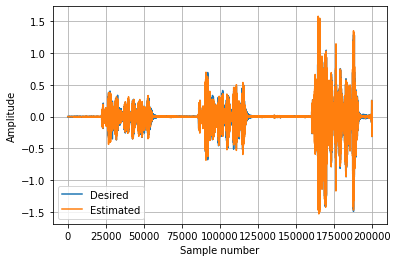

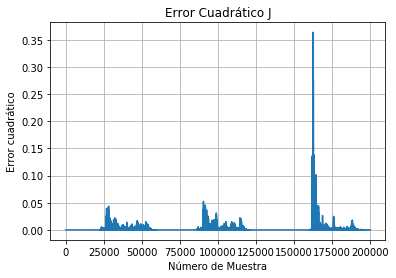

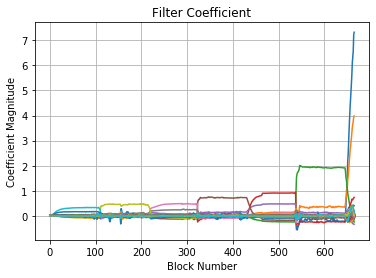

El valor máximo de error cuadrático es 0.3637550176007692
Tardó  6.096634149551392  segundos
Iteración Nº 11
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.6350018412125934, 0.5170750681239077, 1.75]
Se terminó en [1.8850018412125933, 0.5170750681239077, 1.75]


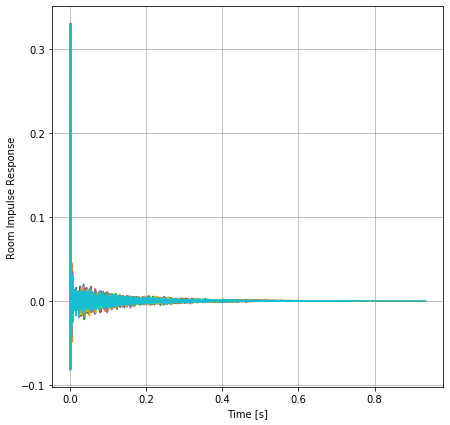

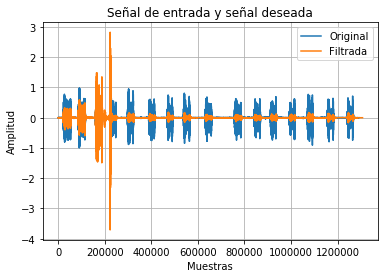

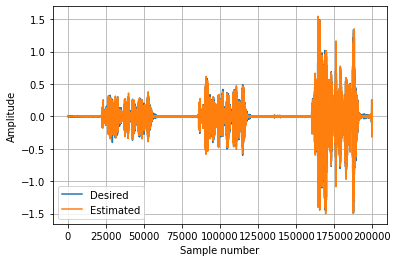

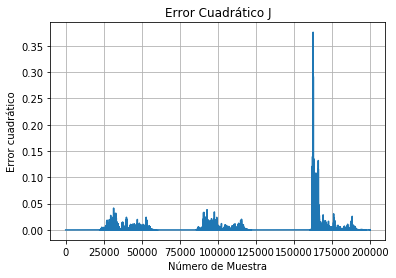

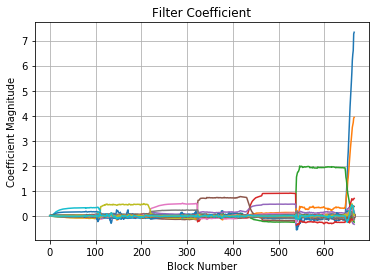

El valor máximo de error cuadrático es 0.3759368067440902
Tardó  5.960702180862427  segundos
Iteración Nº 12
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.4719784815543751, 1.8345847846995849, 1.75]
Se terminó en [1.721978481554375, 1.8345847846995849, 1.75]


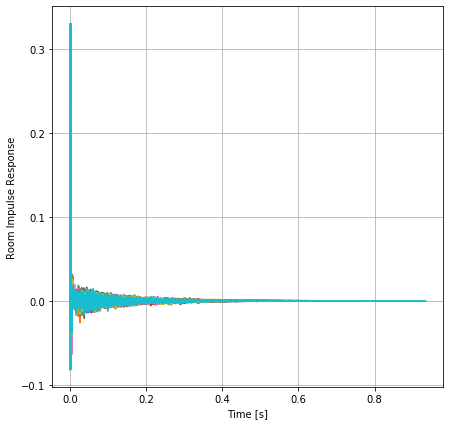

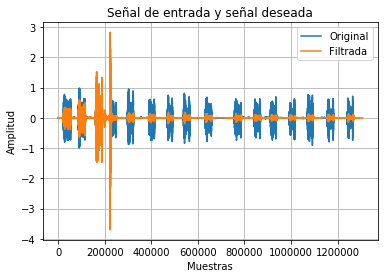

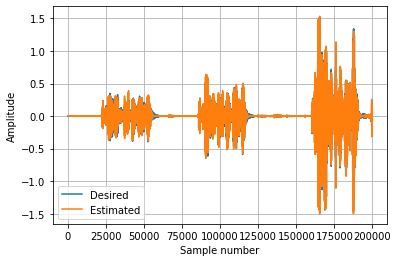

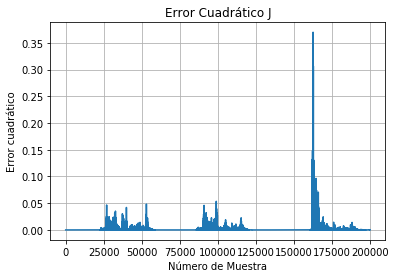

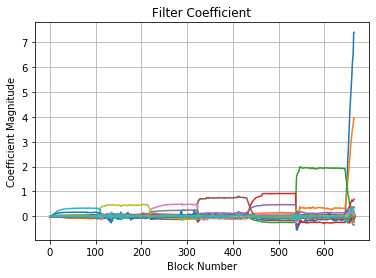

El valor máximo de error cuadrático es 0.3697886612383491
Tardó  6.169344663619995  segundos
Iteración Nº 13
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.1269771230817296, 3.4720652578921984, 1.75]
Se terminó en [1.3769771230817296, 3.4720652578921984, 1.75]


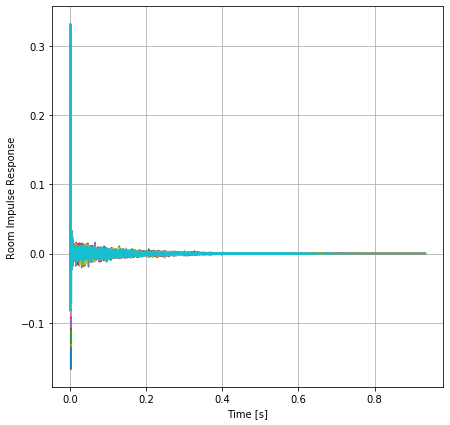

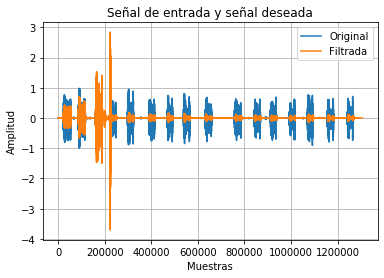

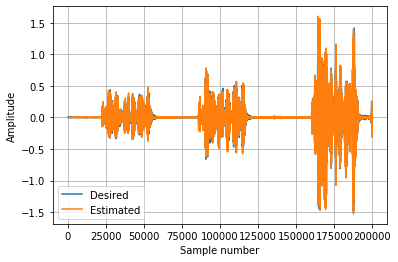

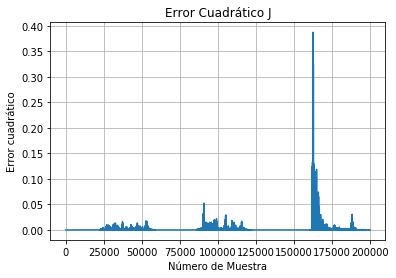

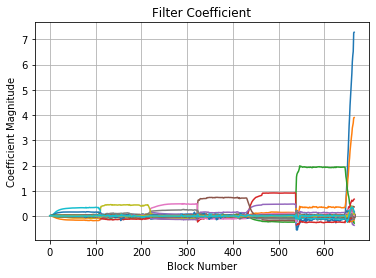

El valor máximo de error cuadrático es 0.38723750253315437
Tardó  5.946137428283691  segundos
Iteración Nº 14
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.07221701721490742, 2.410935913434366, 1.75]
Se terminó en [1.3222170172149075, 2.410935913434366, 1.75]


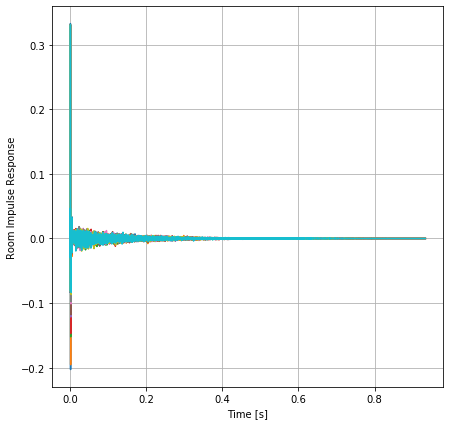

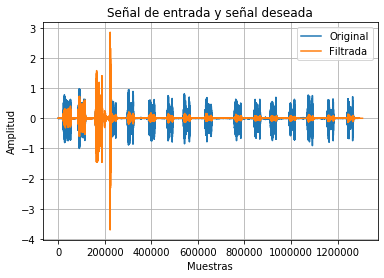

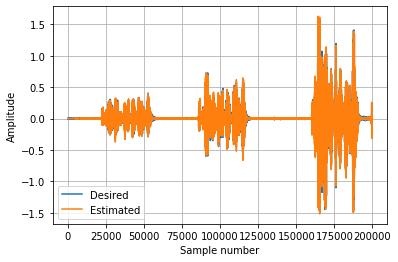

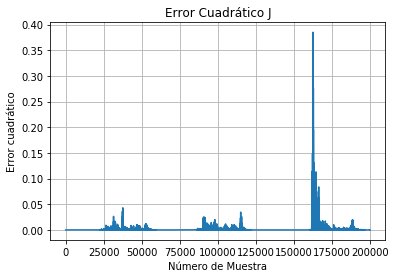

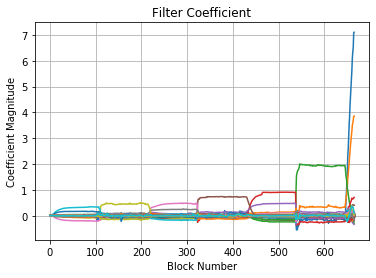

El valor máximo de error cuadrático es 0.38508868603126056
Tardó  6.102665424346924  segundos
Iteración Nº 15
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.4170329985342276, 4.373739426016121, 1.75]
Se terminó en [2.6670329985342276, 4.373739426016121, 1.75]


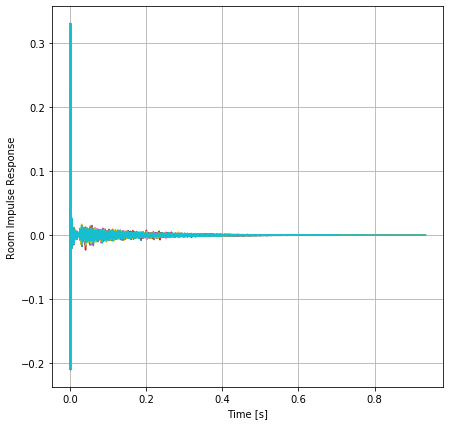

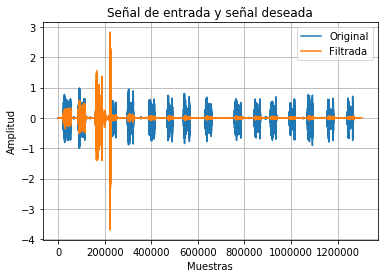

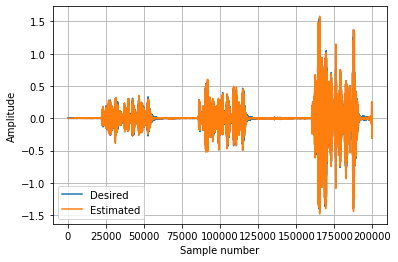

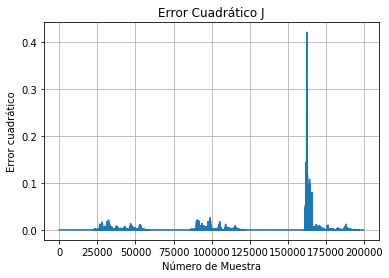

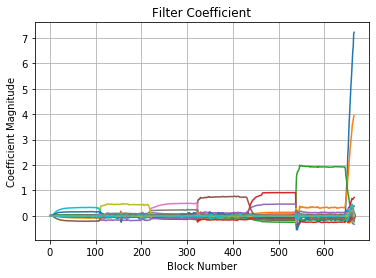

El valor máximo de error cuadrático es 0.4213910658115008
Tardó  5.972888231277466  segundos
Iteración Nº 16
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.4028523810100439, 3.1624828267236667, 1.75]
Se terminó en [1.652852381010044, 3.1624828267236667, 1.75]


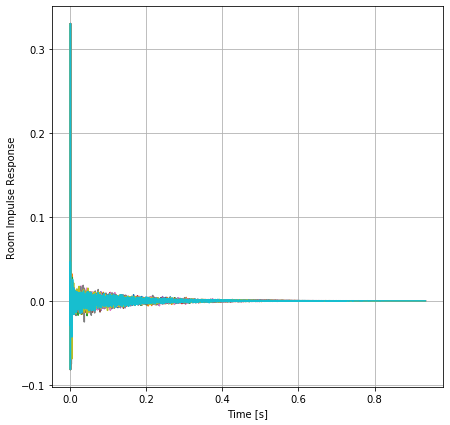

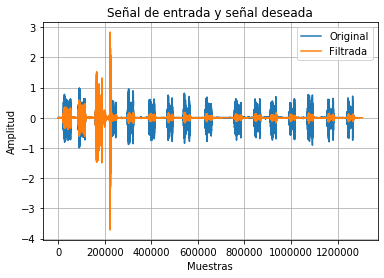

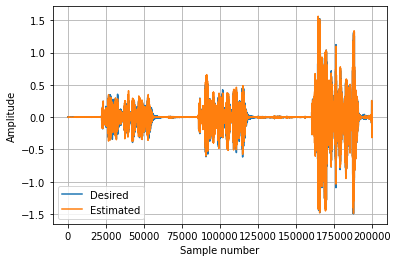

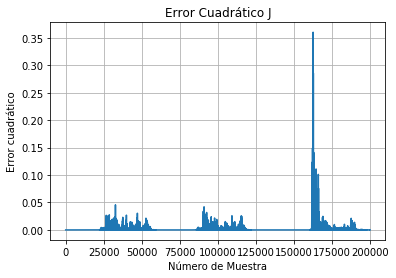

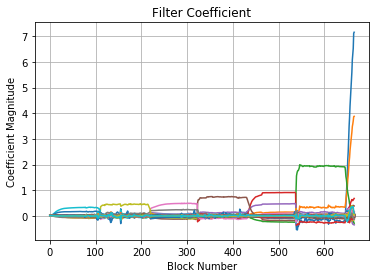

El valor máximo de error cuadrático es 0.3602339893418788
Tardó  6.2880494594573975  segundos
Iteración Nº 17
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.8563308414442825, 3.341054975700347, 1.75]
Se terminó en [2.1063308414442825, 3.341054975700347, 1.75]


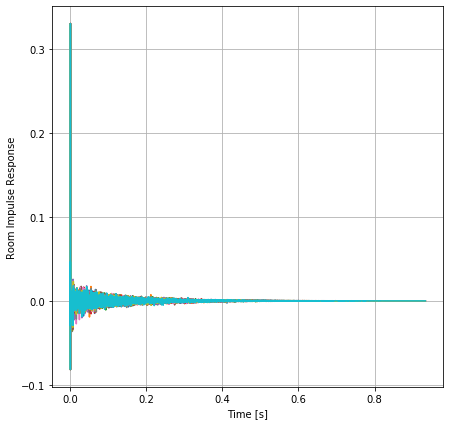

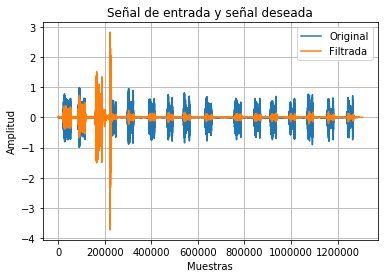

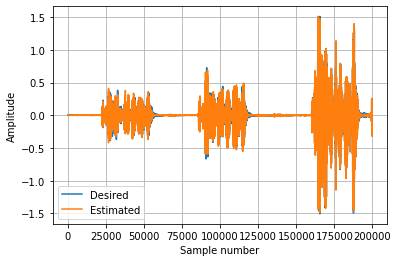

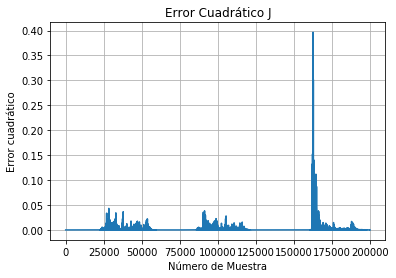

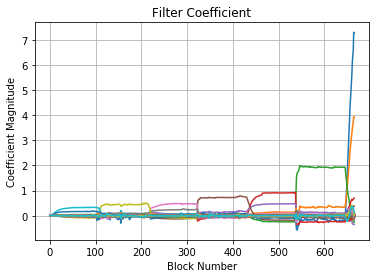

El valor máximo de error cuadrático es 0.3966607649598371
Tardó  6.0070483684539795  segundos
Iteración Nº 18
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.29506784956496673, 1.3567303835530906, 1.75]
Se terminó en [1.5450678495649668, 1.3567303835530906, 1.75]


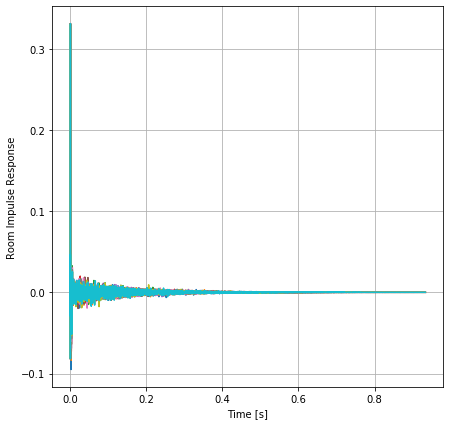

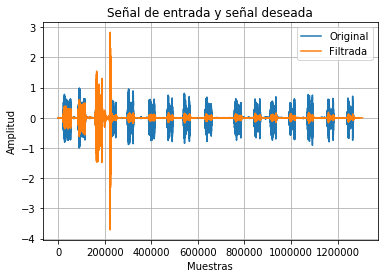

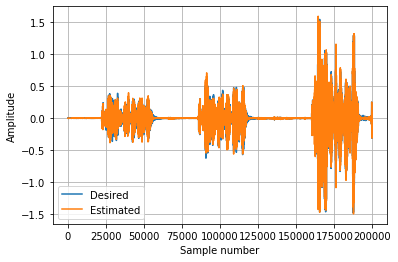

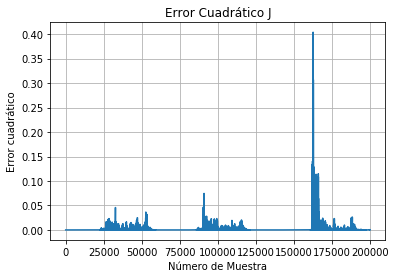

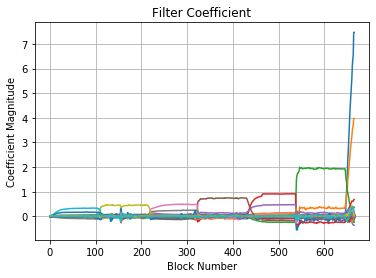

El valor máximo de error cuadrático es 0.40387829323068397
Tardó  6.208671808242798  segundos
Iteración Nº 19
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.415511703830477, 0.7993301024913457, 1.75]
Se terminó en [1.665511703830477, 0.7993301024913457, 1.75]


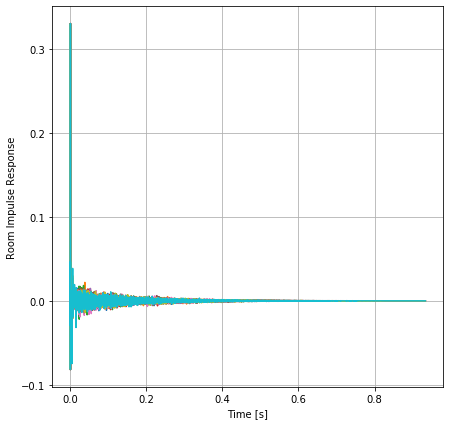

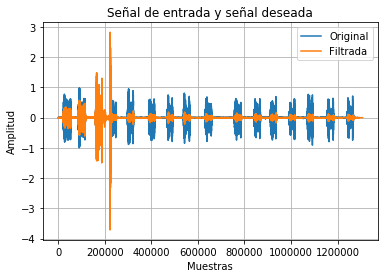

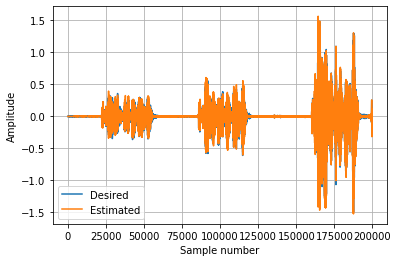

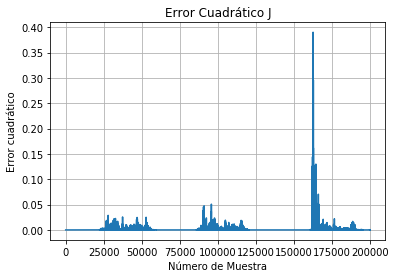

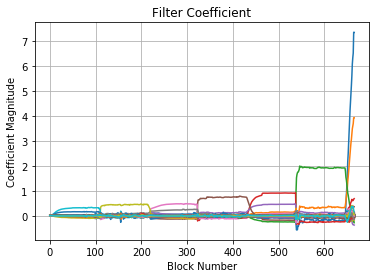

El valor máximo de error cuadrático es 0.39009164744384983
Tardó  6.075582265853882  segundos
Todas las simulaciones tardaron  121.54498744010925  segundos


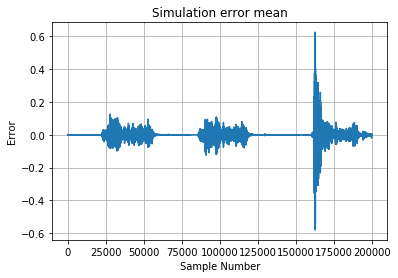

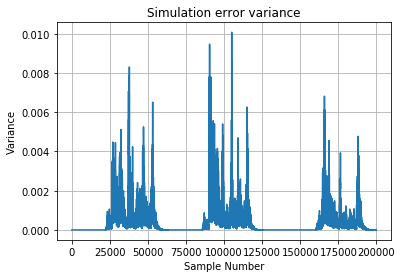

In [44]:
"""A filtered-reference Least-Mean-Square (FxLMS) filter."""

import numpy as np
import matplotlib.pyplot as plt
import time

from adafilt import FastBlockLMSFilter
from adafilt.io import FakeInterface
M = 300
length = M  # number of adaptive FIR filter taps
blocklength = M  # length of I/O buffer and blocksize of filter

number_of_blocks =  test_len//M

room=[3,4.5,2.5]
traj_pts=64

max_runs=20
all_error = zeros((max_runs,number_of_blocks*M))

total_time = time.time()
for runs in range(0,max_runs):

  print("Iteración Nº",runs)
  start_time = time.time()

  #filtered_signal=GetRoomWithMov(audio,room[0],room[1],room[2],traj_pts=40)
  filtered_signal=GetRoomWithMov(audio,test_time,room[0],room[1],room[2],traj_pts=40)

  auxu = (audio[0:test_len])
  auxd = (filtered_signal[0:test_len])

 
  new_auxu = auxu[:number_of_blocks*M]
  new_auxd = auxd[:number_of_blocks*M]
  u = np.array_split(new_auxu,number_of_blocks)
  d = np.array_split(new_auxd,number_of_blocks)

  filt = FastBlockLMSFilter(length, blocklength, power_averaging=0.6,minimum_power=0.0001,stepsize=0.7,constrained=False,normalized=True)

  elog = []
  felog = []
  wslog = []
  ylog = []
  dlog = []

  for i in range(number_of_blocks):

    # filter prediction
    y = filt.filt(u[i])

    # error signal
    e = y - d[i]
    filt.adapt(u[i], e)

    elog.append(e)
    dlog.append(d[i])
    ylog.append(y)
    wslog.append(filt.w)

  y_out=np.concatenate(ylog)
  d_out=np.concatenate(dlog)
  e_out=np.concatenate(elog)
  plt.plot(new_auxd,label="Desired")
  plt.plot(y_out,label="Estimated")
  #plt.plot(new_auxd+1.5,label="Deseada con offset")
  plt.legend(loc='lower left')
  plt.grid(True)
  plt.xlabel('Sample number')
  plt.ylabel('Amplitude')
  plt.show()

  plt.plot(e_out**2)
  plt.grid(True)
  plt.title('Error Cuadrático J')
  plt.xlabel('Número de Muestra')
  plt.ylabel('Error cuadrático')
  plt.show()

  plt.title("Filter Coefficient")
  plt.plot(np.array(wslog))
  plt.xlabel("Block Number")
  plt.ylabel("Coefficient Magnitude")
  plt.grid(True)
  plt.show()

  all_error[runs,:]=e_out
  #eprom=eprom+e_out**2/max_runs

  print("El valor máximo de error cuadrático es",np.amax(e_out**2))

  elapsed_time = time.time() - start_time
  print("Tardó ",elapsed_time," segundos")

tiempo_final = time.time() - total_time
print("Todas las simulaciones tardaron ",tiempo_final," segundos")

emed=zeros(number_of_blocks*M)
evar=zeros(number_of_blocks*M)
for i in range(0,number_of_blocks*M):
  emed[i]=np.mean(all_error[:,i])
  evar[i]=np.var(all_error[:,i])

plt.plot(emed)
plt.grid(True)
plt.title('Simulation error mean')
plt.xlabel('Sample Number')
plt.ylabel('Error')
plt.show()

plt.plot(evar)
plt.grid(True)
plt.title('Simulation error variance')
plt.xlabel('Sample Number')
plt.ylabel('Variance')
plt.show()

In [0]:
emedlms=emed
evarlms=evar

In [0]:
#Audio(new_auxu,rate=fs)

In [0]:
#Audio(new_auxd,rate=fs)

In [0]:
#Audio(y_out,rate=fs)

In [0]:
#Audio(e_out,rate=fs)

##Algoritmo RLS con padasip

In [15]:
!pip install padasip
import numpy as np
import matplotlib.pylab as plt
import padasip as pa 

  Created wheel for padasip: filename=padasip-1.1.1-cp36-none-any.whl size=52973 sha256=950e48014b8cdddd786acdcdfe01a1f63852b7b3fa0b8a881e4e41f7f7015ef2
  Stored in directory: /root/.cache/pip/wheels/64/33/7b/3fe5f0377cb1d58f8f565dc0e718ae80767f8f563e6a77f1ac
Successfully built padasip


La habitación es de 3   4.5   2.5  m
Se arrancó en [1.3859583781211935, 0.6214091579328442, 1.75]
Se terminó en [2.6359583781211935, 0.6214091579328442, 1.75]


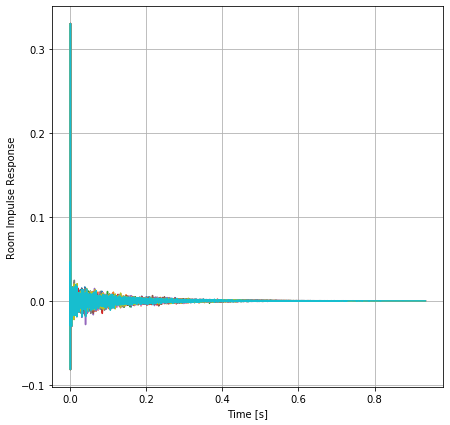

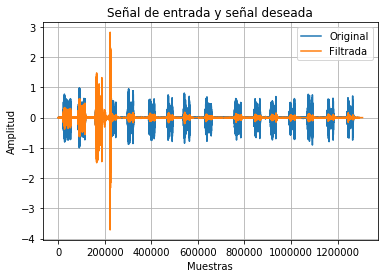

Una simulacion tardo  163.72958302497864  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.3163887713071844, 0.335824459746343, 1.75]
Se terminó en [1.5663887713071845, 0.335824459746343, 1.75]


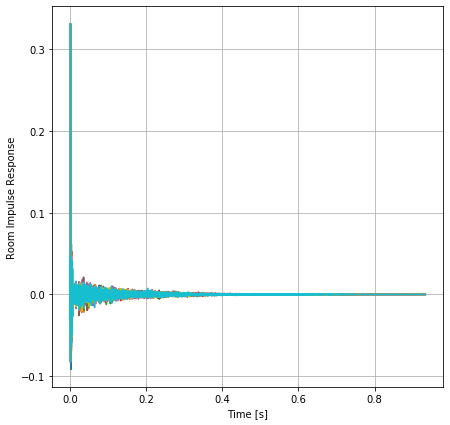

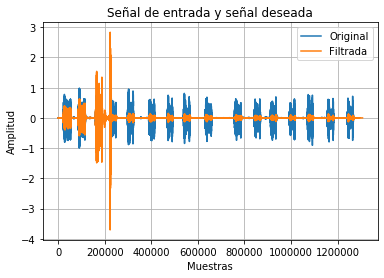

Una simulacion tardo  327.81788444519043  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.9427859412363384, 1.5793103307371084, 1.75]
Se terminó en [2.1927859412363384, 1.5793103307371084, 1.75]


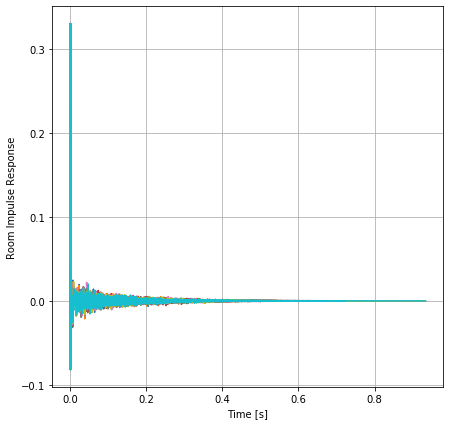

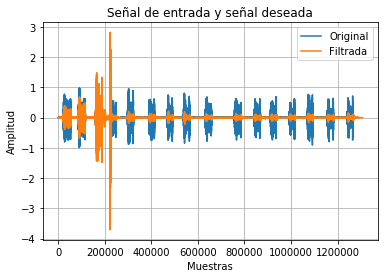

Una simulacion tardo  493.7004656791687  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.1737606956610886, 0.8885673519147478, 1.75]
Se terminó en [2.4237606956610884, 0.8885673519147478, 1.75]


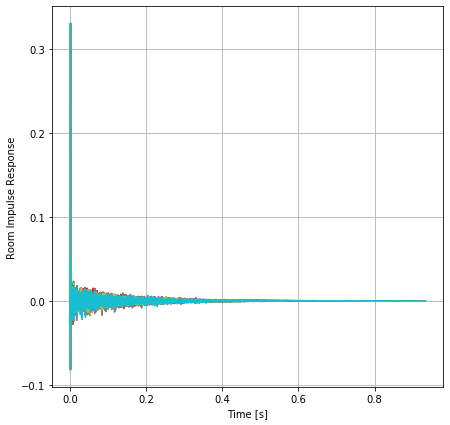

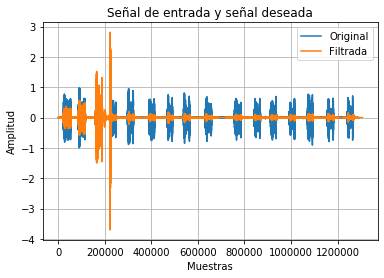

Una simulacion tardo  658.5041372776031  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.1017888544454777, 1.3432434977246024, 1.75]
Se terminó en [2.351788854445478, 1.3432434977246024, 1.75]


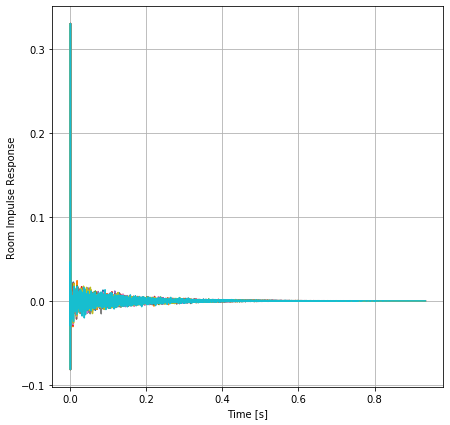

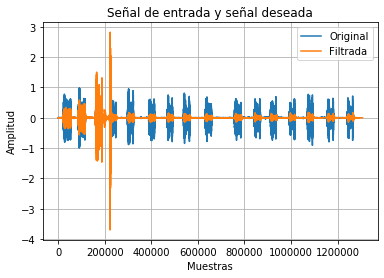

Una simulacion tardo  824.9382925033569  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.3072494119127662, 3.449679845584788, 1.75]
Se terminó en [2.5572494119127662, 3.449679845584788, 1.75]


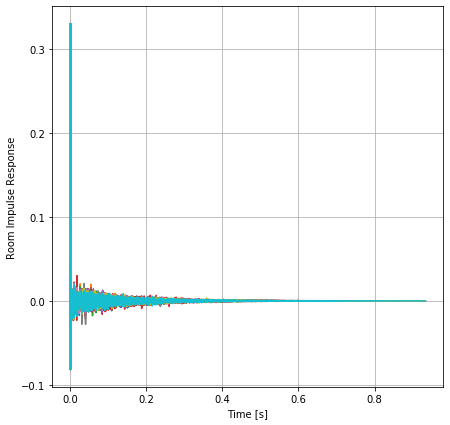

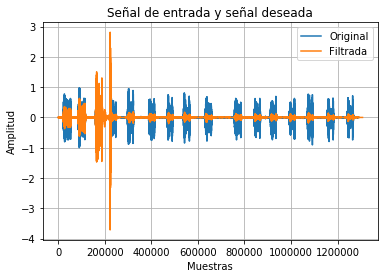

Una simulacion tardo  988.5092236995697  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.1943595084646421, 1.500852542306729, 1.75]
Se terminó en [2.4443595084646423, 1.500852542306729, 1.75]


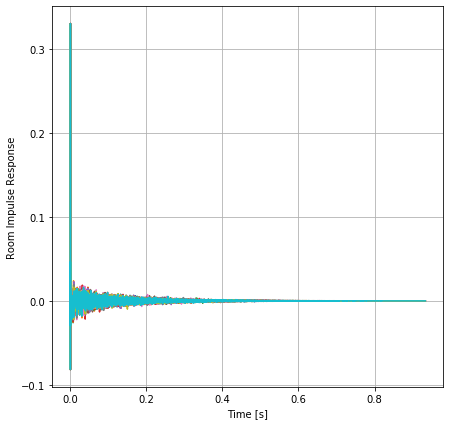

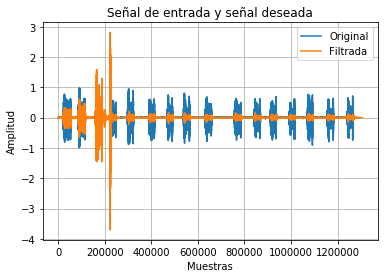

Una simulacion tardo  1155.54989027977  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.1734272587734152, 1.7181280438308646, 1.75]
Se terminó en [1.4234272587734151, 1.7181280438308646, 1.75]


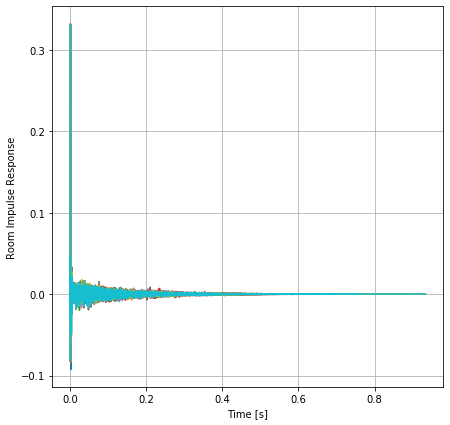

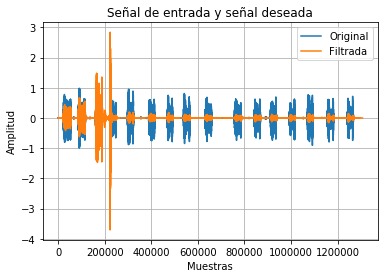

Una simulacion tardo  1318.0504326820374  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [0.9169464205819782, 2.53756500595798, 1.75]
Se terminó en [2.1669464205819784, 2.53756500595798, 1.75]


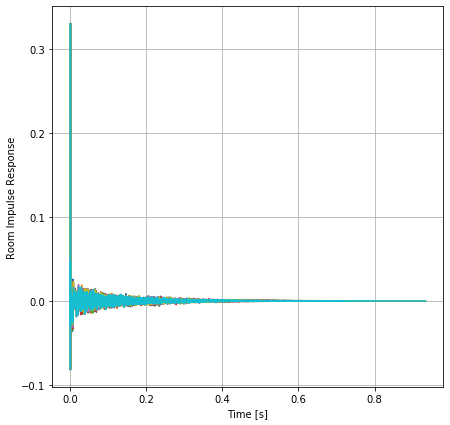

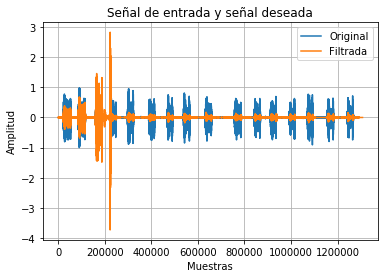

Una simulacion tardo  1482.3572976589203  segundos
La habitación es de 3   4.5   2.5  m
Se arrancó en [1.2065887365647188, 1.7087616138298347, 1.75]
Se terminó en [2.4565887365647185, 1.7087616138298347, 1.75]


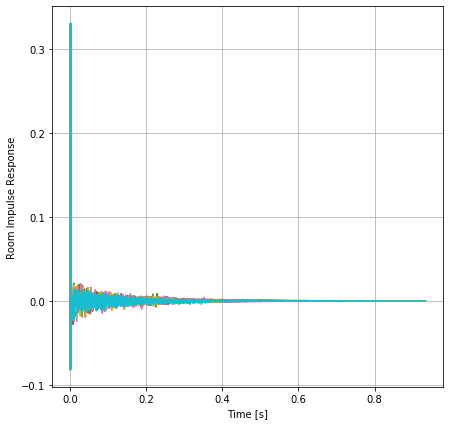

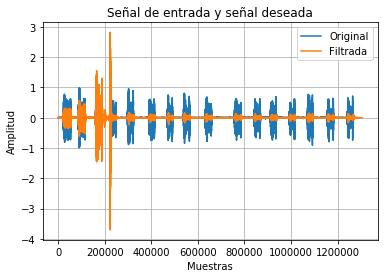

Una simulacion tardo  1646.7036731243134  segundos


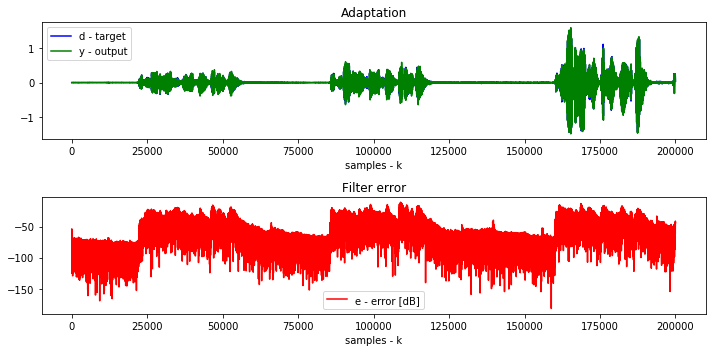

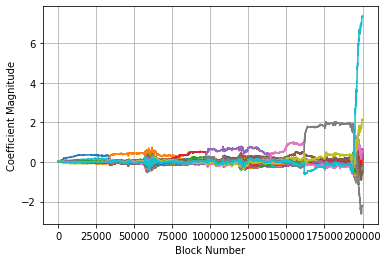

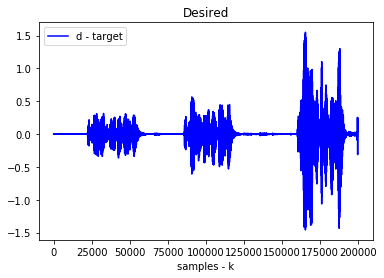

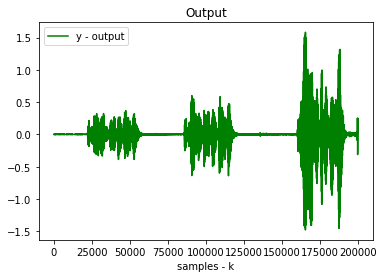

Todas las simulaciones tardaron  1664.0079505443573  segundos


In [46]:
start_time = time.time()

#
filt_order=300

#
test_len=200000

#
test_time=test_len/fs

#
room=[3,4.5,2.5]
traj_pts=64
max_runs=10
all_error = zeros((max_runs,test_len))
for runs in range(0,max_runs):
#
  filtered_signal=GetRoomWithMov(audio,test_time,room[0],room[1],room[2],traj_pts=40)

#
  auxu = (audio[0:test_len])
  auxd = (filtered_signal[0:test_len])
# creation of data
  N = len(auxu)



  temp=np.zeros(len(auxu)+(filt_order-1)*2)
  temp[filt_order-1:filt_order-1+len(auxu)]=auxu
  x = np.zeros((N,filt_order))
  
  d=auxd

  for i in range(len(auxd)):
    x[i,:] = temp[i:i+filt_order]
  f = pa.filters.FilterRLS(n=filt_order, mu=0.05,eps=0.95, w="zeros")
  y, e, w = f.run(d, x)
  all_error[runs,:]=e
  tiempo_final = time.time() - start_time
  print("Una simulacion tardo ",tiempo_final," segundos")
emed=zeros(N)
evar=zeros(N)
for i in range(0,N):
  emed[i]=np.mean(all_error[:,i])
  evar[i]=np.var(all_error[:,i])

#show results
plt.figure(figsize=(10,5))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(d,"b", label="d - target")
plt.plot(y,"g", label="y - output");plt.legend()

plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(e**2),"r", label="e - error [dB]");plt.legend()
plt.tight_layout()
plt.show()

plt.plot(w)
plt.xlabel("Block Number")
plt.ylabel("Coefficient Magnitude")
plt.grid(True)
plt.show()

plt.plot(d,"b", label="d - target");plt.title("Desired");plt.xlabel("samples - k");plt.legend();plt.show()

plt.plot(y,"g", label="y - output");plt.title("Output");plt.xlabel("samples - k");plt.legend();plt.show()

tiempo_final = time.time() - start_time
print("Todas las simulaciones tardaron ",tiempo_final," segundos")

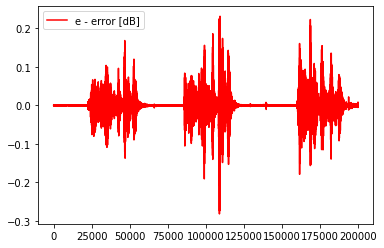

In [47]:
plt.plot((e),"r", label="e - error [dB]");plt.legend()

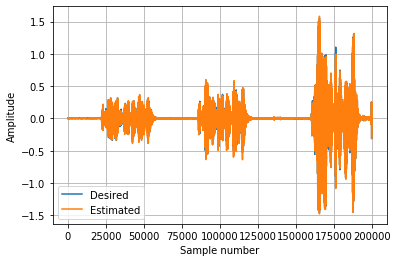

In [48]:
  plt.plot(d,label="Desired")
  plt.plot(y,label="Estimated")
  #plt.plot(new_auxd+1.5,label="Deseada con offset")
  plt.legend(loc='lower left')
  plt.grid(True)
  plt.xlabel('Sample number')
  plt.ylabel('Amplitude')
  plt.show()

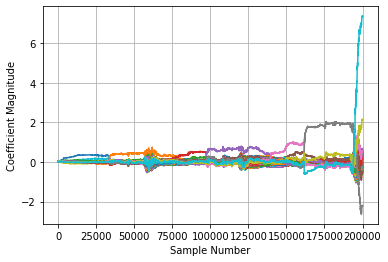

In [55]:
plt.plot(w)
plt.xlabel("Sample Number")
plt.ylabel("Coefficient Magnitude")
plt.grid(True)
plt.show()

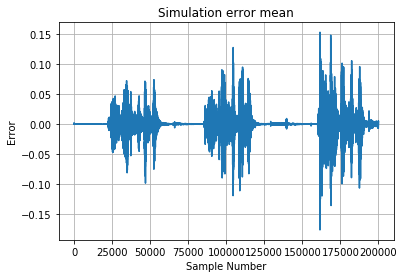

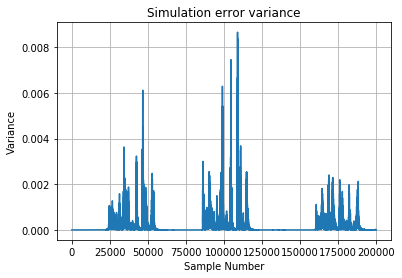

In [51]:
plt.plot(emed)
plt.grid(True)
plt.title('Simulation error mean')
plt.xlabel('Sample Number')
plt.ylabel('Error')
plt.show()

plt.plot(evar)
plt.grid(True)
plt.title('Simulation error variance')
plt.xlabel('Sample Number')
plt.ylabel('Variance')
plt.show()

emedrls=emed
evarrls=evar

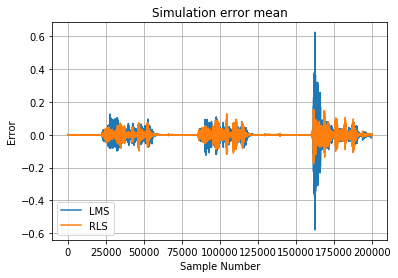

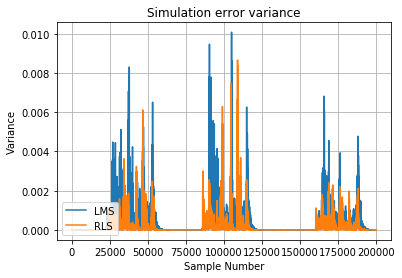

In [54]:
plt.plot(emedlms,label="LMS")
plt.plot(emedrls,label="RLS")
plt.grid(True)
plt.title('Simulation error mean')
plt.xlabel('Sample Number')
plt.ylabel('Error')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

plt.plot(evarlms,label="LMS")
plt.plot(evarrls,label="RLS")
plt.grid(True)
plt.title('Simulation error variance')
plt.xlabel('Sample Number')
plt.ylabel('Variance')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

emedrls=emed
evarrls=evar

In [25]:
Audio(auxu,rate=fs)

In [26]:
Audio(d,rate=fs)

In [20]:
Audio(y,rate=fs)

In [21]:
Audio(d-y,rate=fs)

[[ 1.41158461e-06  1.98965043e-06  1.33049069e-06 ... -3.79711911e-07
  -4.78794713e-07 -7.10389160e-07]
 [ 1.98965043e-06  2.80830522e-06  1.86761724e-06 ... -5.30773204e-07
  -6.74829054e-07 -1.00298028e-06]
 [ 1.33049069e-06  1.86761724e-06  1.28234853e-06 ... -3.70537868e-07
  -4.50109022e-07 -6.66045632e-07]
 ...
 [-3.79711911e-07 -5.30773204e-07 -3.70537868e-07 ...  1.08341901e-07
   1.28471765e-07  1.89115366e-07]
 [-4.78794713e-07 -6.74829054e-07 -4.50109022e-07 ...  1.28471765e-07
   1.62529473e-07  2.40960332e-07]
 [-7.10389160e-07 -1.00298028e-06 -6.66045632e-07 ...  1.89115366e-07
   2.40960332e-07  3.58242007e-07]]
3.5716089720473403e+21


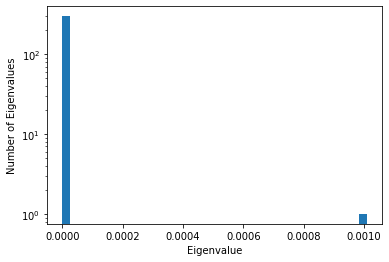

In [65]:
from numpy import linalg as ln

eps=0.95
lamda=0.05
n=10000
phi=eye(filt_order)*eps*lamda**n
for i in range(1,n+1):
  temp=lamda**(n-i)*np.outer(x[i,:],np.transpose(x[i,:]))
  phi=phi+temp
print(phi)

eigs= ln.eigvals(phi)
plt.hist(eigs,bins=40, log=True)
plt.xlabel("Eigenvalue")
plt.ylabel("Number of Eigenvalues")
print(ln.cond(phi))